In [18]:
import pymc3 as pm
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
from scipy.stats import gamma

In [19]:
medical = pd.read_csv('data/insurance2.csv')

In [20]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In [21]:
insurance = medical.charges[medical.insuranceclaim == 1]
no_insurance = medical.charges[medical.insuranceclaim == 0]
n_ins = len(insurance)
n_no_ins = len(no_insurance)

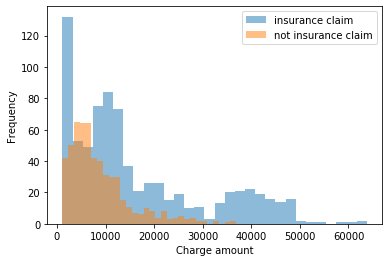

In [22]:
_ = plt.hist(insurance, bins=30, alpha=0.5, label='insurance claim')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='not insurance claim')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

In [23]:
alpha_est = np.mean(no_insurance)**2 / np.var(no_insurance)
beta_est = np.var(no_insurance) / np.mean(no_insurance)
alpha_est, beta_est

(1.8759059725250857, 4702.486170152821)

In [24]:
seed(47)
no_ins_model_rvs = gamma(alpha_est, scale=beta_est).rvs(n_no_ins)

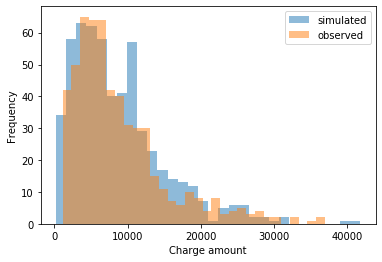

In [25]:
_ = plt.hist(no_ins_model_rvs, bins=30, alpha=0.5, label='simulated')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='observed')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

In [26]:
# PyMC3 Gamma seems to use rate = 1/beta
rate_est = 1/beta_est
# Initial parameter estimates we'll use below
alpha_est, rate_est

(1.8759059725250857, 0.00021265346963636093)

In [39]:
with pm.Model() as model:
    alpha_ = pm.Exponential("alpha_", 1/alpha_est)
    rate_ = pm.Exponential("rate_", 1/rate_est)

    not_insured = pm.Gamma("not_insured", alpha=alpha_, beta=rate_, observed=no_insurance)
    draws = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rate_, alpha_]
Sampling 2 chains, 0 divergences: 100%|██████████| 21000/21000 [00:29<00:00, 705.96draws/s]
The acceptance probability does not match the target. It is 0.8925945164525202, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8974949065750155, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [41]:
first_half = draws[5000:]
alpha = draws['alpha_']
rate = draws['rate_']
beta = 1/rate

In [42]:
mean_alpha = np.mean(alpha)
alpha_percentile = np.percentile(alpha, [2.5, 97.5])
mean_alpha, alpha_percentile

(2.229118674226229, array([1.99372835, 2.48690292]))

In [43]:
mean_rate = np.mean(rate)
rate_percentile = np.percentile(rate, [2.5, 97.5])
mean_rate, rate_percentile

(0.000252642748958691, array([0.00022252, 0.00028496]))

In [44]:
mean_beta = np.mean(beta)
beta_percentile = np.percentile(beta, [2.5, 97.5])
mean_beta, beta_percentile

(3974.0203624773444, array([3509.2211798 , 4493.96904494]))

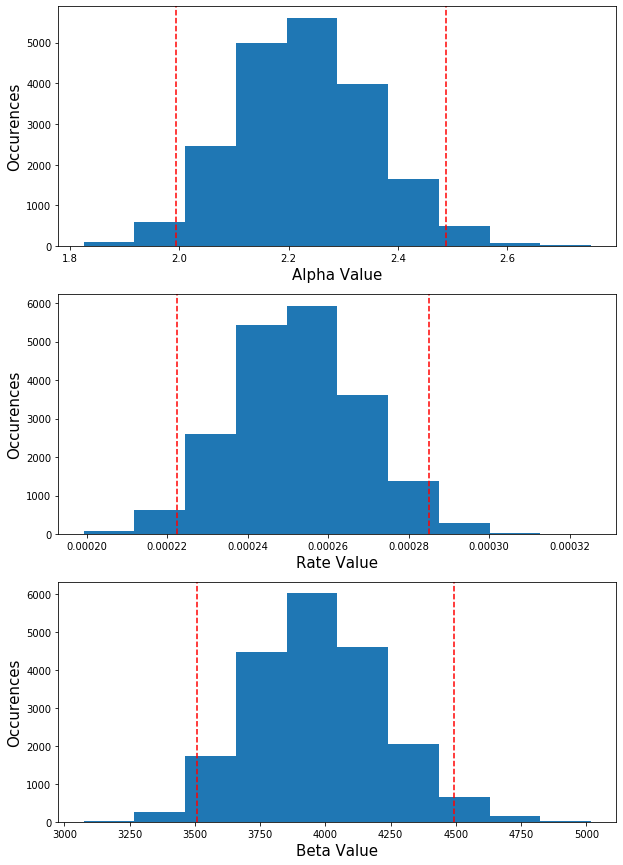

In [46]:
plt.figure(figsize=(10, 15))

plt.subplot(3, 1, 1)
_ = plt.hist(alpha)
_ = plt.axvline(alpha_percentile[0], linestyle='--', color='red')
_ = plt.axvline(alpha_percentile[1], linestyle='--', color='red')
_ = plt.xlabel('Alpha Value', fontsize=15)
_ = plt.ylabel('Occurences', fontsize=15)

plt.subplot(3, 1, 2)
_ = plt.hist(rate)
_ = plt.axvline(rate_percentile[0], linestyle='--', color='red')
_ = plt.axvline(rate_percentile[1], linestyle='--', color='red')
_ = plt.xlabel('Rate Value', fontsize=15)
_ = plt.ylabel('Occurences', fontsize=15)

plt.subplot(3, 1, 3)
_ = plt.hist(beta)
_ = plt.axvline(beta_percentile[0], linestyle='--', color='red')
_ = plt.axvline(beta_percentile[1], linestyle='--', color='red')
_ = plt.xlabel('Beta Value', fontsize=15)
_ = plt.ylabel('Occurences', fontsize=15)

/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend

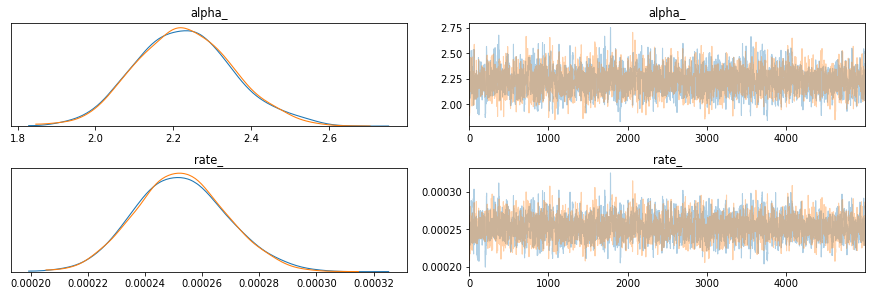

In [49]:
_ = pm.plots.traceplot(first_half)

In [50]:
seed(47)
best_shot_simulated = gamma(alpha.mean(), scale=beta.mean()).rvs(n_no_ins)

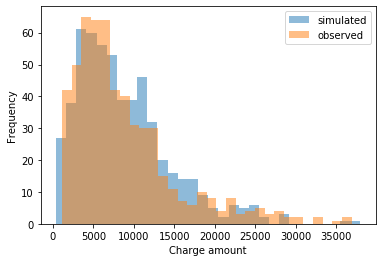

In [51]:
_ = plt.hist(best_shot_simulated, bins=30, alpha=0.5, label='simulated')
_ = plt.hist(no_insurance, bins=30, alpha=0.5, label='observed')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()